# SpaCy Analysis of Clusters From HBDSCAN on Dreaddit labelled dataset
## Using n-grams

## Contents:
* [Presentation](#Presentation)
* [Imports](#Imports)
* [Twitter stressor terms frequency count](Twitter-stressor-terms-frequency-count)
* [Loading Topic Data](#Loading-Topic-Data)
* [Text Preprocessing](#Text-Preprocessing)
* [EDA](#EDA)
* [Summary of unique ngrams per Topic](#Summary-of-unique-ngrams-per-Topic)    


# Presentation 
[[back to contents]](#Contents:)

This notebook is dedicated to exploring the results of our groups work on clustering usign spaCy. Clusters have been developed using HBDSCAN on the Dreaddit labelled dataset. More information about how these clusters have been generated is available in other notebooks. In this notebook, I will be exploring posts from the Dreaddit labelled dataset have been grouped into one of several topics. Some posts have not been put into topics as the HBDSCAN algorithm ignores posts that it believes are outliers. These are identified as having a Topic = -1, and will be ignored for the purpose of this analysis.


The current nlp pipeline involves:
* Creating a spaCy Doc containing the text from all posts in each Topic
* Tokenization of words using the default model provided by spaCy
* Removing stop words
* Selecting the n - grams in each topic

N-grams will be initially investigated to try and determine differences between posts in each Topic. We will try to identify the most important n-grams for each topic and use them as identifiers for further analysis. These n-grams will potentially help to understand the relationship between the clustered topics.

_**Secondary approach:**_
_Before proceeding with extacting the ngrams, I start with first counting the frequency of words in each dreaddit "stressful" post and look up the appearances of the most popular words in the tweeter stressor dataset to evaluate the effectiveness of this approach_ 




# Imports
[[back to contents]](#Contents:)

In [1]:
import pandas as pd
from pattern.en import parsetree, ngrams
from pattern.search import search
from collections import Counter
import random
import spacy
from spacy import displacy
from spacy.tokens import Doc
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')
%config Completer.use_jedi = False

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cncos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cncos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
INTERIM_DATA_FOLDER = os.path.join("..","..", "data", "interim")
RAW_DATA_FOLDER = os.path.join("..", "..", "data", "raw")

# # Run this command to download en_core_web_md if required
# !python -m spacy download en_core_web_md


SPACY_MODEL = "en_core_web_md" # model en_core_web_md includes also word vectors of 300 dimesions. 

In [3]:
nlp = spacy.load(SPACY_MODEL) 

<br/><br/><br/><br/>

# Twitter stressor terms frequency count
## Using NLTK 
[[back to contents]](#Contents:)

The idea here is to count the words in each post that appear in each stressor category, as these categories are given in the tweeter dataset. Then we will look up at the distribution of words and observe if there is any useful conclusions we can make from the counting.

In [4]:
# tweeter post preprocessing 
def lemmatize_stress(corpus):
    lemmatizer = WordNetLemmatizer()
    text=[]
    for term in corpus.termy:
        tokens = [word.lower() for word in nltk.word_tokenize(term)]
        word_tokens = []
        for token in tokens:
            # include only words
                if (re.match( '^[ !"\'()*+-./:;<=>[]^_|~]+$' , token )) or (re.search('^[a-zA-Z]+$', token) and (token not in stopwords) and len(token)>3): 
                    word_tokens.append(lemmatizer.lemmatize(token))
        text.append(" ".join(word_tokens))
    return text


In [5]:
# dreaddit post preprocessing 
def lemmatize_post(corpus):
    lemmatizer = WordNetLemmatizer()
    text=[]
    for term in corpus.post:
        tokens = [word.lower() for word in nltk.word_tokenize(term)]
        word_tokens = []
        for token in tokens:
            # include only words
                if (re.match( '^[ !"\'()*+-./:;<=>[]^_|~]+$' , token )) or (re.search('^[a-zA-Z]+$', token) and (token not in stopwords) and len(token)>3): 
                    word_tokens.append(lemmatizer.lemmatize(token))
        text.append(" ".join(word_tokens))
    return text


In [6]:
#load the sressor tweeter vocabulary 
stressors = os.path.join(RAW_DATA_FOLDER, "twitter_stress_topics_dataset", "stressors_a20n31_topwords.csv")
processed_vocab = os.path.join(INTERIM_DATA_FOLDER, "LIWC_feature_extraction_dreaddit_data.csv")
stressors_voc = pd.read_csv(stressors)
text = lemmatize_stress(stressors_voc)
str_terms = pd.DataFrame([text]).T
sterms = pd.concat([str_terms, stressors_voc.topic_title], axis=1 )
sterms.columns=['terms', 'topic']

In [7]:
# load the LIWC extracted features
LIWC_vocabulary_analysis = pd.read_csv(processed_vocab)


In [8]:
#preprocessing of dreaddit posts
text = lemmatize_post(LIWC_vocabulary_analysis)
LIWC_vocabulary_analysis.post = text

In [9]:
# create vocabulary to hold the posts and top topics resulted from word counting

d = {topic: 0 for topic in sterms.topic}
potential_stressor = {}

for post, ID in zip(LIWC_vocabulary_analysis.post,LIWC_vocabulary_analysis.id) :
    p = post.split()
# reset the word counts for the next post
    d = {key: 0 for key in d}
    for terms, topic in zip(sterms.terms,sterms.topic):
        t = terms.split()
        for word in p:
            if word in t: 
                d[topic]+=1    
#sort the topics for each post by the counted words and retrieve the most popular topics
#these topics will be potentially be related to the stressor of each post 
    top_terms_items = sorted(d.items(), key=lambda item: item[1], reverse = True)[:5]
    top_terms_keys = [key[0] for key in top_terms_items] 
    potential_stressor[ID] = [top_terms_keys]

# create dataframe to hold the results 
pot_stressors = pd.DataFrame(potential_stressor).T.reset_index()
pot_stressors.columns=['id', 'stressors']
stressors_analysis= pd.merge(LIWC_vocabulary_analysis.iloc[:,:3], pot_stressors, on = 'id')



In [10]:
# dataframe to hold only stressed posts
stress_posts = stressors_analysis[stressors_analysis.label==1].reset_index(drop=True)
pn = 2
print(stress_posts.post[pn], '\n\n')
print(stress_posts.stressors[pn], '\n\n')



boyfriend amazing kind sweet good student like thing family like dont feel passion rush felt truth started going boyfriend secretly time really didnt feel nothing disgusting didnt even want touch feel didnt want still kinda realized felt nothing love related hurt knew dating even begged stay course problem boyfriend dont feel like love like thing kinda feel love feel catch thinking time time remembering good thing drive crazy know wont feel love mind make think still recently found girl actually enjoying experience hurt know dont right feel felt betrayed still feel gross 


['positive affect', 'feeling pain', 'family', 'feeling overwhelmed', 'relationships'] 




We see that from the above tweeter labels the matching oif these to the context of the post is not ideal. We need to use other methods to try identify the stressors in the posts. 

<br/><br/><br/><br/>

# Loading Topic Data
[[back to contents]](#Contents:)


We currently have two models for generating clusters. The first uses feature reduction using UMAP before clustering with HDBSCAN (Ines). Posts with Topic = -1 were not clustered by the HDBSCAN algorithm and shall be ignored for the purpose of this analysis.

In [11]:
df = pd.read_pickle(os.path.join(INTERIM_DATA_FOLDER, "unsupervised_clustering_UMAP_HDBSCAN_results.p"))
df.rename(columns={'Post': 'text'},inplace=True)

In [12]:
df['Topic'].value_counts()

-1     1892
 12     427
 30     157
 14     109
 3       94
 28      83
 31      77
 33      76
 6       66
 21      40
 10      37
 13      34
 25      33
 32      33
 18      31
 4       27
 1       26
 16      23
 8       22
 26      21
 5       20
 22      20
 17      20
 20      19
 23      19
 27      18
 34      16
 15      15
 29      14
 19      14
 2       13
 0       12
 11      12
 9       11
 24      11
 7       11
Name: Topic, dtype: int64

The second clustering model involves running the HDBSCAN on the LIWC features.

In [13]:
df2 = pd.read_csv(os.path.join(INTERIM_DATA_FOLDER, "hdbscan_liwc_results.csv"), index_col=0 )

In [14]:
df2['Topic'].value_counts()

-1     1652
 9      642
 13     611
 7      272
 5      109
 0       50
 4       41
 6       32
 2       28
 8       25
 3       23
 1       20
 11      17
 10      16
 12      15
Name: Topic, dtype: int64

From the value counts, it appears that the second method was able to put more posts into one of the clusters. This is shown by the lower number of the -1 Topic - posts that have been identified.

# Text Preprocessing
[[back to contents]](#Contents:)

To explore the text in these dataframes, I will first convert the posts to spaCy Docs so that further text processing can be performed. To do this, I will first create the following function that creates a spaCy Doc from all of the posts from a specific dataframes Topic. 

In [15]:
def get_topic_doc_from(df, topic=0):
    """
    Creates spaCy Doc from posts labelled with a Topic
    
    Parameters
    ----------
    df : pandas.DataFrame()
        dataframe containing posts and topics
        posts must be in a ['text'] column
        topics must be in a ['Topic'] column
    topic : int (optional)
        topic that the posts have been labelled with.
    
    Returns
    -------
    topic_doc : spacy.tokens.doc.Doc
        All of the text from posts labelled with the topic
    n_posts : int
        The number of posts in labelled with the topic
    """
    topic_df = df[df['Topic'].values == topic]
    topic_text = topic_df['text']
    list_topic = topic_text.tolist()
    n_posts = len(list_topic)
    #create a list of spacy posts
    doc = list(nlp.pipe(list_topic))
    #put together all posts into a spacy document
    topic_doc = Doc.from_docs(doc)
    return topic_doc, n_posts

The spaCy Doc still contains features such as punctuation and stopwords. The following function selects only the nouns from each Topic Doc. 

As each Topic has a different number of posts, the number of occurrences of a specific noun can not be directly compared between two Topics. Instead, the relative frequency of occurrence (% of noun presence in a topic) of each noun should be used. This is calculated by dividing the number of occurrences of the noun in a Topic by the number of posts in a Topic. The following function returns the frequency of occurrences of each noun in a given Topic in descending order.

In [16]:
def get_topic_noun_from(topic_doc):
    """
    Creates list of tuples containing nouns and their frequency of occurrences in a Topic
    
    Parameters
    ----------
    topic_doc : spacy.tokens.doc.Doc
        All of the text from posts labelled with the topic
    
    Returns
    -------
    topic_noun_count : list(noun, count)
        list of tuples of containing nouns and their count in a Topic
    """
    topic_nouns = [token.text for token in topic_doc if token.pos_ == "NOUN" and token.is_stop != True]
    topic_noun_count = Counter(topic_nouns)
    return topic_noun_count

I use the pattern library's **search** function to find the combinations of: <p> 
- Adjectives + Nouns 
- Nouns + Nouns and 
- Verbs + Nouns

Often powerful word combinations consist of these grammatical terms. Examples are _**cloud computing** , **sexual abuse**_.
<br>

Note that the patterns library has a **ngrams** function but this is not preferred in this instance as the ngrams will pick up combinations of words which do not have a significant meaning. 

In [17]:
def get_topic_ngrams_from(topic_doc):
    """
    Creates list of tuples containing ngrams and their frequency of occurrences in a Topic.
    Ngrams are based on: 
    JJ + NN: adjective followed by noun e.g sexual abuse
    NN + NN: noun followed by noun e.g cloud computing 
    VB + NN: verb follwed by noun e.g killed me
    
    Parameters
    ----------
    topic_doc : spacy.tokens.doc.Doc
        All of the text from posts labelled with the topic
    
    Returns
    -------
    bigrams_dict : dictionary of bigrams with their occurences in the topic
    bigrams count: count of bigrams 
        tuple containing the dictionary of bigrams and the count of bigrams
    """
    search_terms = [("VB NN"), ("JJ NN"), ("NN NN")]
    
    
    #the code below runs unitl the call of parstree module returns a valid result.
    #due to a bag in the pastree module the first times the module is called it 
    #returns a StopIteration Error. 
    error = True
    while error:
        try:
            s= parsetree(topic_doc[0].text, relations=True, lemmata=True)
            error = False
        except:
            error = True
    
    
    bigrams_batch = []
    for i, terms in enumerate(search_terms):
        result = search(terms, s)
        if len(result)>0:
            bigrams = [(match.string.lower(), terms) for match in result if bool(re.search('^[a-zA-Z]', match.string)) ]
            bigrams_batch.append((bigrams, terms))
    bigrams_sum = [item for sublist in bigrams_batch for item in sublist[0]]
    bigrams_dict = dict(Counter(bigrams_sum))
    bigrams_count = len(dict(Counter(bigrams_sum)))
    return bigrams_dict, bigrams_count
    
    
    

In [18]:
def ngrams_freq_unique(df):
    """
    Creates dictionary of all ngrams and their frequency of occurrences throughout all Topics
    
    Parameters
    ----------
    df : pandas.DataFrame()
        dataframe containing posts and topics
        posts must be in a ['text'] column
        topics must be in a ['Topic'] column
    
    Returns
    -------
    topic_ngrams_freq : dict()
        dictionary of ngrams and their frequency of occurrence thoughout all Topics
    ngrams_unique : dict()
        dictionary of the importance (uniqueness) of each ngram to each topic
    """
    #get the number of all topics. All topics found in topic modelling -1 for the non clustered topics 
    topic_n = df['Topic'].nunique() - 1
    Topic_bigrams_dict = {'Topic_'+ str(i) : [] for i in range(0,topic_n)}
    for i in range(0,topic_n):
        topic_doc = get_topic_doc_from(df, topic=i)
        bigrams_dict, bigrams_count = get_topic_ngrams_from(topic_doc)
        Topic_bigrams_dict['Topic_'+ str(i)] = bigrams_dict    
        
    # create list of unique ngrams
    All_bigrams_dict_keys = [Topic_bigrams_dict[topic].keys() for topic in Topic_bigrams_dict]
    all_keys_list = list(set([keys for dict_keys in All_bigrams_dict_keys for keys in dict_keys]))
    
    # count all times that a particular ngram appears throughout all topics in all posts
    all_key_counts = {}
    for key in all_keys_list:
        counts=0
        for topic in Topic_bigrams_dict:
            if key in Topic_bigrams_dict[topic].keys():
                counts += Topic_bigrams_dict[topic][key]
        all_key_counts[key] = counts
        
    # create ditionary of ngrams uniqueness. Uniqueness explains how much is a particular ngram unique to a particular topic
    ngrams_unique = Topic_bigrams_dict.copy()
    for topic in ngrams_unique: 
        ngrams_unique[topic] = ngrams_unique[topic].fromkeys(ngrams_unique[topic], 0)

    for topic in Topic_bigrams_dict:
        for key in Topic_bigrams_dict[topic].keys():
            ngrams_unique[topic][key] = Topic_bigrams_dict[topic][key]/ all_key_counts[key]

    return Topic_bigrams_dict, ngrams_unique, all_key_counts


    
    


In [19]:
Topics_bigrams, ngrams_unique, all_key_counts =  ngrams_freq_unique(df2)


In [20]:
# sorted(all_key_counts.items(), key = lambda x : x[1], reverse = True)[:50]

# EDA
[[back to contents]](#Contents:)

A nice method of text visualisation are wordclouds. These following functions outputs the ngrams from a given topic as a word cloud. The greater the number of occurrences of the noun in the wordcloud, the larger the size of the word. 
Let's visualise through word clouds the ngrams which are most popular among all topics.

In [21]:
def popular_ngrams_wordcloud(all_key_counts, n=10):
    """
    Creates wordcloud for the most popular ngrams throughout all Topics
    
    Parameters
    ----------
    all_key_counts : dict()
        dictionary containing the counts of all ngrams
        across all Topics. 
        must be in format { ('n_gram', 'part_of_speech') : number_of_occurences }
        
    n : int (optional)
        define the number of the most popular ngrams 
        to illustrate in the wordcloud.
        
    Returns
    -------
    wordcloud : WordCloud()
        wordcloud of ngrams based on their number of occurrences in all Topics
    """
    top_bigrams = dict(sorted(all_key_counts.items(), key =  lambda x: x[1], reverse = True)[:n])
    ngram = {item[0] : top_bigrams[item] for item in top_bigrams}
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(ngram)
    plt.imshow(wordcloud, interpolation='bilinear')







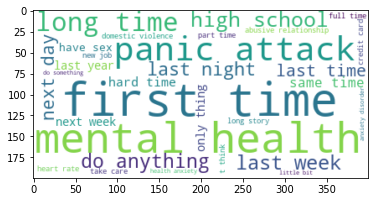

In [22]:
popular_ngrams_wordcloud(all_key_counts, n=30)

Definitely from the cloud we observe some powerful ngrams able to provide good indication of the post's sentiment such as: <p>
Mental health, $\;\;$ Panic attack, $\;\;$ Abusive relationship 
<p>
It is not clear how ngrams such as first time, long time, same, time etc will have a significant meaning for sentiment analysis. Words like this tend to have similar behaviour to stopwords but this is to be investigated further.

## Summary of unique ngrams per Topic
[[back to contents]](#Contents:)

The table below summarises all unique ngrams per Topic. The score 0-1 defines the uniquness of a ngram in a particular Topic, ie. the ngram does not exist in other Topics with 1 meaning the ngram is unique; a value closer to 0 means that the ngram appears in too many of the Topics.

In [23]:
def create_ngrams_table(Topic_bigrams_dict, ngrams_unique):
    """
    Creates a dataframe withe the unique ngrams for each Topic.
    
    Parameters
    ----------
    Topic_bigrams_dict : dict()
        dictionary containing the unique ngrams for each topic. 
        must be in format {  Topic_0: { ('n_gram', 'part_of_speech') : number_of_occurences.. },
                             Topic_1: { ('n_gram', 'part_of_speech') : number_of_occurences.. }..}  
        
        
    Returns
    -------
    ngrams_table : pd.DataFrame()
        
    """
    d = {topic : [] for topic in ngrams_unique}
    for topic in ngrams_unique:
        for item in ngrams_unique[topic]:
            if ngrams_unique[topic][item]==1:
                d[topic].append(item[0])
    df = [ pd.DataFrame(data= d[topic], columns = ["Topic_"+str(i)]) for i, topic in enumerate(d) ] 
    ngrams_table = pd.concat(df, axis=1, keys=['N-grams']*14)
    return ngrams_table
    

In [24]:
ngrams_table = create_ngrams_table(Topics_bigrams, ngrams_unique)
ngrams_table

N-grams                                                \
                    Topic_0                     Topic_1           Topic_2   
0                   get doe                let anything          find god   
1              donate stuff             obvious trigger  consider sharing   
2          involve gambling                  big time(i      jewish woman   
3     biological sleepiness                other family      ncjw shelter   
4        pavlovian response  career/financial stability       entire hood   
...                     ...                         ...               ...   
1302                    NaN                         NaN               NaN   
1303                    NaN                         NaN               NaN   
1304                    NaN                         NaN               NaN   
1305                    NaN                         NaN               NaN   
1306                    NaN                         NaN               NaN   

                                                                         \
            Topic_3        Topic_4          Topic_5             Topic_6   
0     try something       see jail     tell someone               i use   
1         come talk   face apology      delete part      present moment   
2     make anything     afford oil      accept help         enough room   
3        real thing  seem interest   gauge conflict         regular sex   
4      restless leg     do someone  plan everything  emotional intimacy   
...             ...            ...              ...                 ...   
1302            NaN            NaN              NaN                 NaN   
1303            NaN            NaN              NaN                 NaN   
1304            NaN            NaN              NaN                 NaN   
1305            NaN            NaN              NaN                 NaN   
1306            NaN            NaN              NaN                 NaN   

                                                                     \
               Topic_7      Topic_8        Topic_9         Topic_10   
0         improve life   eat peanut      see title    need coddling   
1     increase empathy  lose weight     fuck buddy      have advice   
2      raise awareness   afford ice    drunk drive  afford anything   
3            see <url>    tap water  have dwarfism    stop worrying   
4         please share     eat rice  have anything   avoid lavender   
...                ...          ...            ...              ...   
1302               NaN          NaN            NaN              NaN   
1303               NaN          NaN            NaN              NaN   
1304               NaN          NaN            NaN              NaN   
1305               NaN          NaN            NaN              NaN   
1306               NaN          NaN            NaN              NaN   

                                                                       
                     Topic_11          Topic_12              Topic_13  
0                     old kid       know anyone             go doctor  
1     roommate-type situation      hostile room  take methylphenidate  
2                   new state  residential care           take charge  
3                   next town     further abuse      disconnect today  
4                  only place     painful death           see someone  
...                       ...               ...                   ...  
1302                      NaN               NaN        driver license  
1303                      NaN               NaN     software engineer  
1304                      NaN               NaN     anxiety subreddit  
1305                      NaN               NaN                 m ill  
1306                      NaN               NaN               one day  

[1307 rows x 14 columns]

While the unique ngrams is possible to exist just because of the length of the posts and do not carry any significance in the sentiment analysis, it is useful to look at the most popular ngrams which were found in the step above and categorise them in stressors.

Since we do not have labelled data on stressors, an automated process which will look at the distribution of these ngrams in the various stressor categories, is not feasible. Therefore we will look manually the ngrams and subjectively allocate them in stressor categories.

To reduce the bias of the subjective decission, it is good for the ngrams categorisation to be done by a group of at least 5 persons.

## Training the Word2Vec model on dreaddit dataset
[[back to contents]](#Contents:)

Here I will use the Word2Vec (https://radimrehurek.com/gensim/models/word2vec.html) deep learning architecturep to train the model and produce word embeddings for our corpus tokens.
Thereafter I will use the stressor titles to find words which are similar to these and that will give good indication regarding the stressor.

This will help us to expand the list of keyword patterns we are looking to match with the stress posts, using spaCy PhraseMatcher. 

In [25]:
import gensim.downloader 
import gensim
from gensim.models import KeyedVectors


In [26]:
def create_doc_sentences(df):
    """
    Creates a list of lists, containing the spaCy posts (sentences) to be used for the word embedding training.
    
    Parameters
    ----------
    df : pandas.DataFrame()
        dataframe containing posts and topics
        posts must be in a ['text'] column
        topics must be in a ['Topic'] column

    Returns
    -------
    sentences : list of list of spaCy documents 
    """
    sentences = []
    topic_n = len(df2['Topic'].value_counts()) - 1
    for topic in range(topic_n):
        topic_df = df2[df2['Topic'].values == topic]
        topic_text = topic_df['text']
        list_topic = topic_text.tolist()
        #create a list of spacy posts
        doc = list(nlp.pipe(list_topic))
        #put the same topic post in the sentences list for the word embedding training
        sentences.append(doc)
    return sentences

In [27]:
sentences = create_doc_sentences(df2)

In [28]:
len(sentences)

14

In [29]:
filtered_tokens_per_topic= []
for sublist in sentences:
    for post in sublist:
        filtered_tokens = [token.text.lower() for token in post if (not token.is_stop) and token.is_alpha]
        filtered_tokens_per_topic.append(filtered_tokens)
    

In [30]:
# instantiate a model to be trained on the stressor posts clustered by topic

model = gensim.models.Word2Vec(
        sentences = filtered_tokens_per_topic,
        vector_size = 100,
        window=10,
        min_count=3,
        workers=6,
        epochs=20)



In [31]:
stress_categories = ['family', 'school', 'relationship', 'future', 'self', 'financial', 'social', 'home', 'mental', 'career', 'abuse', 'health']

#define lists for filling with stressor keywords
family_keywords = []
school_keywords = []
relationship_keywords = []
future_keywords = []
self_keywords = []
financial_keywords = []
social_keywords = []
home_keywords = []
mental_keywords = []
career_keywords = []
abuse_keywords = []
health_keywords = []

#!! It is important to keep the order of the lists the same as the order of the stress_categories in the list above
keyword_lists = [ family_keywords, school_keywords, relationship_keywords, future_keywords, self_keywords, financial_keywords, social_keywords,
                home_keywords, mental_keywords, career_keywords,abuse_keywords, health_keywords ]

#create dictionary of keywords per stressor category
stressor_keys = dict(zip(stress_categories,keyword_lists))

for i, key in enumerate(stressor_keys):
    try:
        similar = model.wv.most_similar(key, topn=20)
        for word in similar:
            keyword_lists[i].append(word[0])
        stressor_keys[key] = set(keyword_lists[i])
    except:
        pass



The following keys will be passed on as patterns to the spaCy PhraseMatcher to observe the detection of stressors in the posts. I am caucious about using these terms though, as the Word2Vec model has been trained only on the dreaddit dataset which is limited and this method may cause the predition to overfit on the training set. 


In [32]:
print(stressor_keys)

{'family': {'smaller', 'jewish', 'wife', 'brother', 'visit', 'kids', 'creepy', 'cousins', 'son', 'siblings', 'tuition', 'niece', 'children', 'grandpa', 'stepfather', 'custody', 'child', 'parents', 'sister', 'father'}, 'school': {'new', 'stay', 'city', 'getting', 'late', 'apartment', 'college', 'town', 'packed', 'cleared', 'hotel', 'beaten', 'niece', 'room', 'fed', 'freshman', 'diploma', 'living', 'home', 'high'}, 'relationship': {'abused', 'married', 'sweet', 'ex', 'guy', 'girl', 'met', 'boyfriend', 'abusive', 'man', 'past', 'dynamic', 'times', 'highschool', 'abuse', 'sexual', 'tongue', 'dating', 'dated', 'f'}, 'future': {'studying', 'flow', 'main', 'uk', 'y', 'phase', 'hey', 'posts', 'copy', 'treating', 'aware', 'success', 'nature', 'progress', 'everybody', 'season', 'pattern', 'curve', 'canada', 'o'}, 'self': {'situations', 'embarrassment', 'possibly', 'triggers', 'familiar', 'honest', 'occurred', 'anger', 'understanding', 'sends', 'negative', 'typical', 'lead', 'overthinking', 'look